In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import numpy as np
import yaml
import gammapy
print("gammapy:", gammapy.__version__, " (needs to be v.19)")
from scipy import linalg
import astropy.units as u 
from astropy.coordinates import SkyCoord, Angle
from gammapy.maps import Map, MapAxis
from gammapy.datasets import (
    Datasets,
    MapDataset,
    FluxPointsDataset
)
from gammapy.modeling.models import (
    SkyModel,
    PointSpatialModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    Models, 
    SpatialModel, 
    FoVBackgroundModel
)
from gammapy.modeling import Fit, Parameter, Parameters,Covariance
from gammapy.estimators import FluxPointsEstimator
import sys
#from my_dataset_maps_k_19 import My_MapDataset
#from  my_dataset_core_k_19 import My_Dataset,My_Datasets 
#from my_estimator_points_sed import My_FluxPointsEstimator
from my_dataset_maps_19 import MapDatasetNuisance
import my_fit_19


gammapy: 0.19  (needs to be v.19)


# choose your source and model

In [2]:
source = 'Crab'
pos = SkyCoord(83.6333313*u.deg, 22.01444435*u.deg, frame='icrs')
mask_sources = [[pos.ra.deg, pos.dec.deg, 0.4]] # given as a list, position and size

from gammapy.modeling.models import GaussianSpatialModel, LogParabolaSpectralModel
spatial=GaussianSpatialModel(lon_0=83.6333313*u.deg, lat_0=22.01444435*u.deg, sigma=0.016*u.deg, reference='1 TeV', frame='icrs')
spectral=LogParabolaSpectralModel(amplitude='3.84e-11 cm-2 s-1 TeV-1', alpha=2.5, beta=0.105, reference='1TeV')
main_source= SkyModel(spatial_model=spatial, spectral_model=spectral, name='main source')

In [3]:
'''source = 'NGC253'
pos = SkyCoord(83.6333313*u.deg, 22.01444435*u.deg, frame='icrs')
mask_sources = [[pos.ra.deg, pos.dec.deg, 0.4]] # given as a list, position and size

from gammapy.modeling.models import PointSpatialModel, PowerLawSpectralModel
spatial=PointSpatialModel(lon_0=11.8875*u.deg, lat_0=-25.2883*u.deg, reference='1 TeV', frame='icrs')
spectral=PowerLawSpectralModel(amplitude='1.79e-13 cm-2 s-1 TeV-1', index=2.848)
main_source= SkyModel(spatial_model=spatial, spectral_model=spectral, name='main source')'''

"source = 'NGC253'\npos = SkyCoord(83.6333313*u.deg, 22.01444435*u.deg, frame='icrs')\nmask_sources = [[pos.ra.deg, pos.dec.deg, 0.4]] # given as a list, position and size\n\nfrom gammapy.modeling.models import PointSpatialModel, PowerLawSpectralModel\nspatial=PointSpatialModel(lon_0=11.8875*u.deg, lat_0=-25.2883*u.deg, reference='1 TeV', frame='icrs')\nspectral=PowerLawSpectralModel(amplitude='1.79e-13 cm-2 s-1 TeV-1', index=2.848)\nmain_source= SkyModel(spatial_model=spatial, spectral_model=spectral, name='main source')"

# starting point

In [4]:
# loading general parameters

with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
repo_path=cfg['repo_path']
N_ebins = cfg['N_ebins']
zen_bins = cfg['zen_bins']
energy_bins = np.logspace(-1, 2, N_ebins+1)

In [5]:
stacked = MapDataset.read(f'{source}/stacked.fits')
sys_er = np.loadtxt(f'{source}/sysamplitude.txt')
downsampling_factor = 25
l_deg = 0.1

# checks of dataset

In [6]:
original_mask_safe = stacked.mask_safe.data.copy()
x_axis=stacked.counts.geom.axes['energy'].center.value

for mask_pos in mask_sources:
    stacked.mask_safe &= ~stacked.counts.geom.region_mask(f"icrs;circle({mask_pos[0]}, {mask_pos[1]}, {mask_pos[2]})")

In [7]:
stacked.mask_safe = Map.from_geom(geom=stacked.counts.geom, data=original_mask_safe) 

#with open(f'{source}/standard_model.yml',  "r") as ymlfile:
#    best_fit_model = yaml.load(ymlfile, Loader=yaml.FullLoader)
##with open(f'{source}/standard_bgmodel.yml',  "r") as ymlfile:
#    best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
    
    
best_fit_model =  main_source

bkg_model = FoVBackgroundModel(dataset_name=stacked.name)
#bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
#bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
models = Models([best_fit_model])
models.append(bkg_model)
stacked.models =models
print(stacked.models)

DatasetModels

Component 0: SkyModel

  Name                      : main source
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   3.84e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    alpha                   :      2.500   +/-    0.00             
    beta                    :      0.105   +/-    0.00             
    lon_0                   :     83.633   +/-    0.00 deg         
    lat_0                   :     22.014   +/-    0.00 deg         
    sigma                   :      0.016   +/-    0.00 deg         
    e            (frozen)   :      0.000                   
    phi          (frozen)   :      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : MvsbFJlj-bkg
  Datasets names            : ['MvsbFJlj']
  Spectral model type  

# analysis with gammapy

## Definition of Variables

In [8]:
geom_down = stacked.geoms['geom'].downsample(downsampling_factor)
print(
    "spatial binsize of the standard dataset = ",
    stacked.geoms["geom"].width[1]
    / stacked.geoms["geom"].data_shape[1],
)



print('Creating Mask for Nuisance Parameters where sysamplitude==0')
nui_mask = sys_er>0
print('nui_mask:',nui_mask)
nuisance_mask = Map.from_geom(geom_down, dtype=bool)
for e, n in enumerate(nui_mask):
    nuisance_mask.data[e,:,:] = n
    
    
print()
ndim_spatial_1D     = stacked.geoms['geom'].data_shape[1]
ndim_spatial_nui_1D = geom_down.data_shape[1]
ndim_spatial_nui    = ndim_spatial_nui_1D **2
ndim_spectral_nui   = np.count_nonzero(nui_mask)
ndim_3D_nui         = ndim_spectral_nui*ndim_spatial_nui



print(' Nuisance Parameter Geometry')
print()
print(f'Orign Spatial dim  :  {ndim_spatial_1D} x {ndim_spatial_1D}')
print(f'                   ={ndim_spatial_1D**2 :>20}')

print(f'Downsampling factor:{downsampling_factor:>20}')
print(f'Spatial dimension:  {ndim_spatial_nui_1D} x {ndim_spatial_nui_1D}')
print(f'                   ={ndim_spatial_nui:>20}')
print(f'Spectral dimension: {ndim_spectral_nui:>20}')
print(f'Total dimension:    {ndim_3D_nui:>20}')
print(f"pix / deg:          {geom_down.data_shape[1]/geom_down.width[0][0].value:>20} 1/deg "  )
print(f"deg / pix:          {geom_down.width[0][0].value/ geom_down.data_shape[1]:>20} deg" )



spatial binsize of the standard dataset =  [0.08] deg
Creating Mask for Nuisance Parameters where sysamplitude==0
nui_mask: [False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]

 Nuisance Parameter Geometry

Orign Spatial dim  :  150 x 150
                   =               22500
Downsampling factor:                  25
Spatial dimension:  6 x 6
                   =                  36
Spectral dimension:                   18
Total dimension:                     648
pix / deg:                           0.5 1/deg 
deg / pix:                           2.0 deg


## Correlation Matrix

In [9]:
# new way to compute correlation matrix to make it symmetric/ invertible
# into Gaussian: sigma **2  * exp(...), where sigma  is the systematic amplitude in %
# if it is saved in terms of std it has to be transformed! 

sys_map = Map.from_geom(geom_down).slice_by_idx(dict(energy=slice(0,ndim_spectral_nui)))
e = 0
sys_map.data = np.ones_like(sys_map.data)
for ii in np.arange(len(sys_er)):
    if sys_er[ii] >0.0:
        if stacked.npred_background().downsample(downsampling_factor).data[ii,:,:].sum() > 0:
            sys_map.data[e,:,:] *= sys_er[ii]/ ndim_spatial_nui 
            print(sys_er[ii]/ ndim_spatial_nui )
        e+=1


0.23547429704039155
0.5603309334388331
0.6244368473781167
0.1950607349577239
0.10425623710439623
0.0994997834606064
0.08869638733896196
0.30576703917735254
0.1719856688541152
0.18708303327444928
0.18488557223091662
0.21682318678448795
0.053587539148928554
0.07489038655157863
0.10066425249410607
0.09419410611490724
0.1498238711163367
0.13653351892808108


/tmp/ipykernel_2054/2156954341.py:12: RuntimeWarning: invalid value encountered in true_divide
  ax[1][1].plot(sys_er / np.sqrt(bg) )


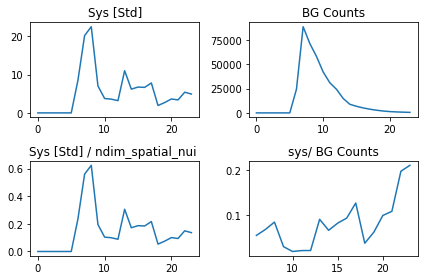

In [10]:
fig, ax = plt.subplots(2,2)
ax[0][0].plot(sys_er)
ax[0][0].set_title('Sys [Std]')

ax[1][0].plot(sys_er / ndim_spatial_nui )
ax[1][0].set_title('Sys [Std] / ndim_spatial_nui ')

bg = stacked.npred_background().downsample(downsampling_factor).data.sum(axis=2).sum(axis =1)
ax[0][1].plot(bg )
ax[0][1].set_title('BG Counts')

ax[1][1].plot(sys_er / np.sqrt(bg) )
ax[1][1].set_title('sys/ BG Counts')

plt.tight_layout()


In [11]:
sigma = sys_map.data[:,0,0] # = sys_er[ii]/ ndim_spatial_nui 
sigma = (sys_er / np.sqrt(bg))[sys_er>0]
l_corr = 0.001

geom_down = nuisance_mask.geom
helper_map = Map.from_geom(geom_down).slice_by_idx(dict(energy=slice(0, 1)))
helper_map2 = helper_map.copy()


def compute_K_matrix(l_deg):
    corr_matrix_spatial = np.identity(ndim_spatial_nui)
    for b_0 in range(ndim_spatial_nui_1D):
        for l_0 in range(ndim_spatial_nui_1D):
            i = b_0 * ndim_spatial_nui_1D + l_0
            C = SkyCoord(
                helper_map.geom.pix_to_coord((l_0, b_0, 0))[0],
                helper_map.geom.pix_to_coord((l_0, b_0, 0))[1],
                frame=geom_down.frame,
            )
            helper_map.data[0, :, :] = C.separation(
                geom_down.to_image().get_coord().skycoord
            ).value
            helper_map2.data = np.zeros(ndim_spatial_nui_1D ** 2).reshape(
                helper_map2.geom.data_shape
            )
            helper_map2.data[0, :, :] = np.exp(
                -0.5 * helper_map.data[0, :, :] ** 2 / l_deg ** 2
            )
            corr_matrix_spatial[i, :] = helper_map2.data.flatten()

    corr_matrix_spectral = np.identity(ndim_spectral_nui)
    for e in range((ndim_spectral_nui)):
        corr_matrix_spectral[e, e] = sigma[e] ** 2
    return np.kron(corr_matrix_spectral, corr_matrix_spatial)

/tmp/ipykernel_2054/4200769510.py:2: RuntimeWarning: invalid value encountered in true_divide
  sigma = (sys_er / np.sqrt(bg))[sys_er>0]


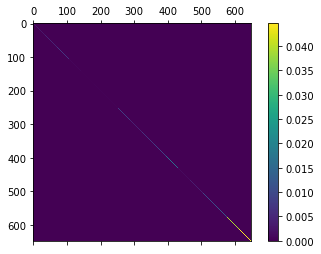

In [12]:
correlation_matrix = compute_K_matrix(l_corr)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation_matrix)  # interpolation='nearest')
fig.colorbar(cax);

In [13]:
if np.allclose(np.dot(correlation_matrix, np.linalg.inv(correlation_matrix)), 
               np.identity(len(correlation_matrix))):
    print('Matrix is invertible.')
else:
    print('WARNING: The coorelation matrix may not be invertible!')



Matrix is invertible.


In [14]:
# Freeze Nuisance parameters at the edges of the analysis
bg_map  = stacked.background.downsample(downsampling_factor)
bg = bg_map.data[nui_mask].flatten()
stat_err_ = np.sqrt(bg)
threshold = 500
Nuisance_parameters = [Parameter(name = "db"+str(i), value = 0,frozen = False)  
            if sys_map.data.flatten()[i]  * threshold < stat_err_[i] 
            else  Parameter(name = "db"+str(i), value = 0,frozen = True)
      for i in range(ndim_3D_nui)]
ii = 0
for i in Nuisance_parameters:
    if i.frozen == False:
        ii += 1
print(ii, ' free Nuisance Parameters out of ', ndim_3D_nui)
Nuisance_parameters = Parameters( Nuisance_parameters)


16  free Nuisance Parameters out of  648


In [15]:
print('======== Dataset with Nui Par ==========')

dataset_N = MapDatasetNuisance(
            background=stacked.background,
            exposure=stacked.exposure,
            psf=stacked.psf,
            edisp=stacked.edisp, 
            mask_fit=stacked.mask_fit,
            mask_safe=stacked.mask_safe,
            counts = stacked.counts,
            inv_corr_matrix = np.linalg.inv(correlation_matrix),
            N_parameters = Nuisance_parameters,
            nuisance_mask = nuisance_mask
            )

#dataset_N.apply_mask_safe()
bkg_model = FoVBackgroundModel(dataset_name=dataset_N.name)
models = Models(stacked.models.copy())
models.append(bkg_model)
dataset_N.models = models
print(dataset_N)


======== Dataset with Nui Par ==========
MapDatasetNuisance
------------------

  Name                            : wXbo9y3Q 

  Total counts                    : 417131 
  Total background counts         : 387882.91
  Total excess counts             : 29248.09

  Predicted counts                : 419794.41
  Predicted background counts     : 387882.89
  Predicted excess counts         : 31911.52

  Exposure min                    : 1.39e+00 m2 s
  Exposure max                    : 2.25e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180540 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1251367.20

  Number of models                : 2 
  Number of parameters            : 12
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : main source
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : Gauss

In [16]:
fit_N = my_fit_19.Fit( )
result_N = fit_N.run([dataset_N])
print(result_N)
n_parameters = [float(n) for n in dataset_N.N_parameters.value ]

print('After the fit:')
print(dataset_N.models)


Position <SkyCoord (ICRS): (ra, dec) in deg
    (89.09546826, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (89.09546826, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (78.17119434, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (78.17119434, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.6333313, 27.44400828)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.6333313, 27.44400828)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.6333313, 16.49820823)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoo

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 1149
	total stat : -1251637.22

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 1149
	total stat : -1251637.22


After the fit:
DatasetModels

Component 0: SkyModel

  Name                      : main source
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   3.70e-11   +/- 2.8e-13 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    alpha                   :      2.510   +/-    0.02             
    beta                    :      0.105   +/-    0.01             
    lon_0                   :     83.631   +/-    0.00 deg         
    lat_0                   :    

In [17]:
save = 0
if save:
    dataset_N.write(f'{source}/nui_dataset.fits', overwrite = True)
    with open(f'{source}/nui_par.yml', 'w') as outfile:
            yaml.dump(dataset_N.N_parameters.to_dict(), outfile, default_flow_style=False)
    with open(f'{source}/nui_bgmodel.yml', 'w') as outfile:
            yaml.dump(dataset_N.background_model.to_dict(), outfile, default_flow_style=False)
    with open(f'{source}/nui_model.yml', 'w') as outfile:
            yaml.dump(dataset_N.models.to_dict(), outfile, default_flow_style=False)        


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


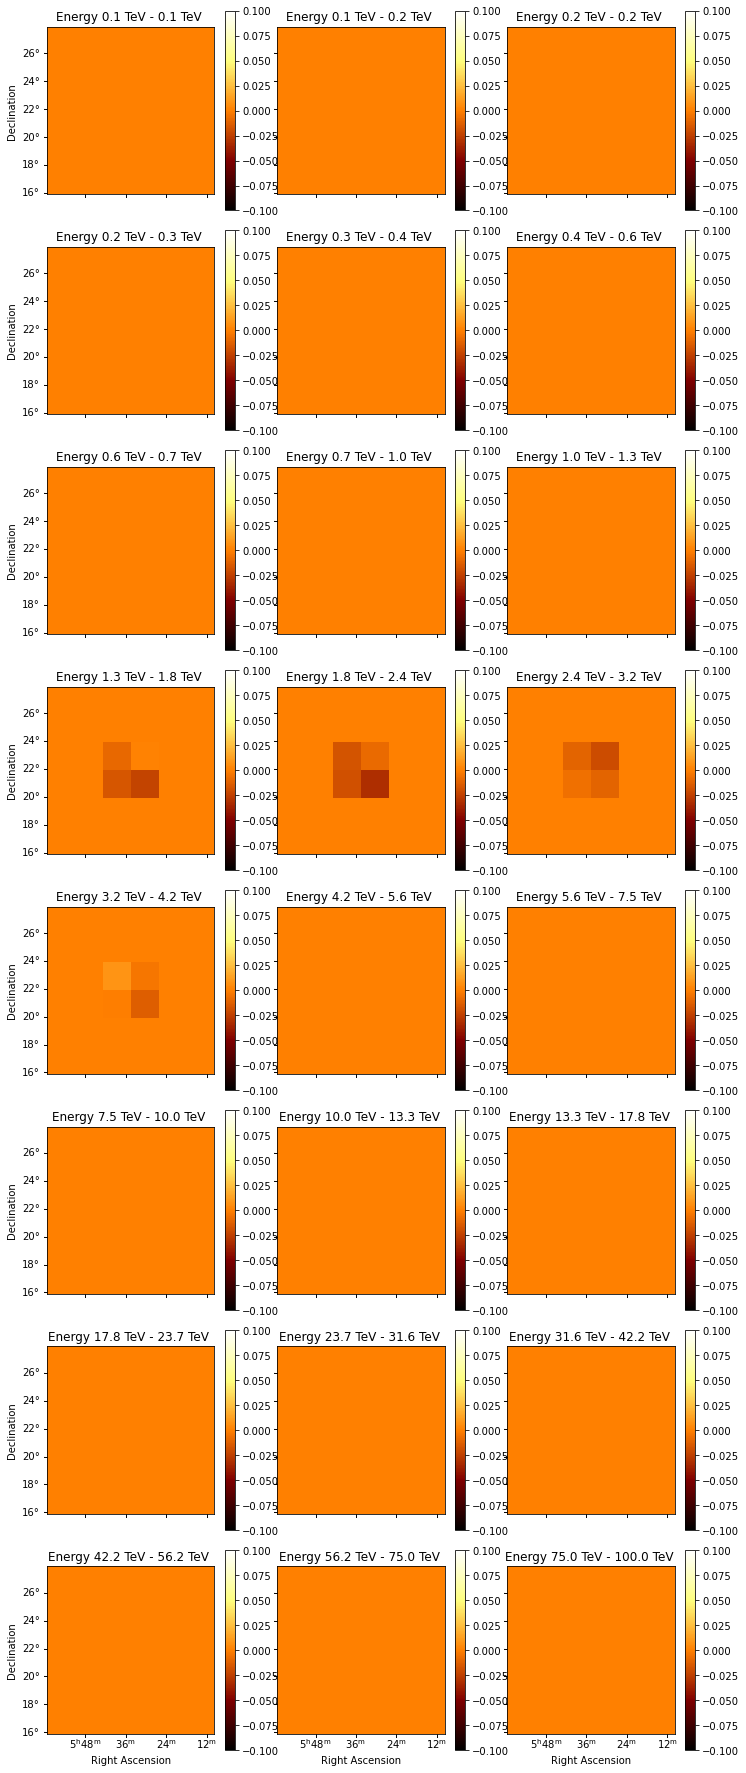

In [18]:
dataset_N.N_map().plot_grid(add_cbar = 1, vmin = -0.1, vmax = 0.1);

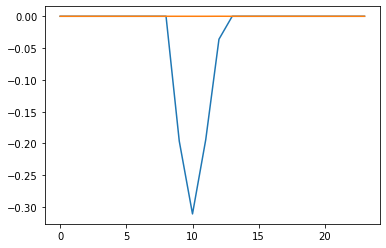

In [19]:
plt.plot(dataset_N.N_map().data.sum(axis=2).sum(axis=1)/ ndim_spatial_1D)
plt.plot(dataset_N.N_map().data.max(axis=2).max(axis=1)/ ndim_spatial_1D)

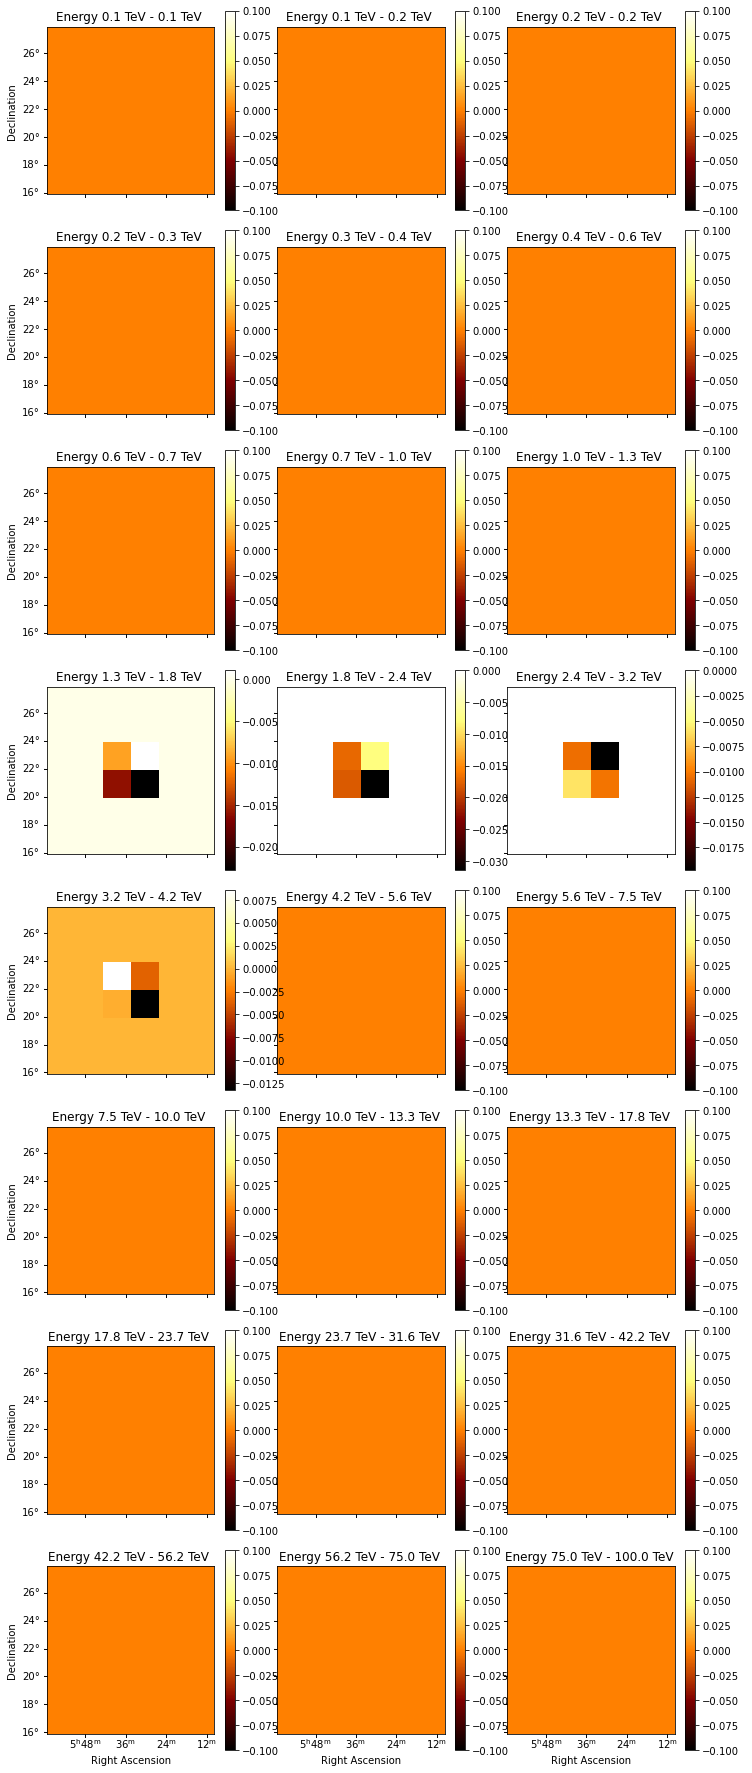

In [20]:
dataset_N.N_map().plot_grid(add_cbar = 1);